## Similarity to self (the halo effect)

1) We depend on taking two equal independent (no replacement) samples from each metrical form (or metrical variant) and  running the clusterization. ARI/purity should be high to register the effect of within-meter semantic coherence  
2) We distiguish between **metrical forms** (Iamb-4) and **metrical variants** (Iamb-4-mf) and run tests on availiable groups of poems independently  


In [1]:
### load libraries & data
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)

#calculations

#library(proxy)
library(philentropy)
library(mclust) # ARI
library(NMF) # Cluster purity
#dendrograms

library(ape)
library(ggtree) # Bioconductor installation
library(phylogram)
#library(ggdendro)

#visuals
library(hrbrthemes)
library(paletteer)
library(patchwork)
library(DT)



source("src/poem_sampler.R")
source("src/test_clusters_halo.R")
load("data/lda_output.rda")

options(repr.plot.width = 8, repr.plot.height = 6,unit="cm")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map


Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.2.4  For help: https://yulab-smu.github.io/treedata-book/

If you use ggtree in published research, please cite the most appropriate paper(s):

- Guangchuang Yu. Using ggtree to visualize data on tree-like structures. Current Protocols in Bioinformatics, 2020, 69:e96. doi:10.1002/cpbi.96
- Guangchuang Yu, Tommy Tsan-Yuk Lam

## Consensus tree


1) calculates h. clusters for each sample, converts to trees -> repeat  
2) build consensus tree with ape, draw unrooted tree with ggtree

In [2]:
source("src/consensus_tree_within_meter.R")

set.seed(123)
trees = consensus_tree_within_meter(x=unique_poems,
                           y=meter_count,
                           z=ru_gamma_separated,
                           sample_size=200,
                           n_samples=2,
                           n_trees = 100,
                           min_meter_count=500,
                           replace=F,
                           distance="JSD",
                           clust_method="complete")

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

In [3]:
trans = translation  %>% rename(class = meter)
library(ggtree)
consensus = ape::consensus(trees, p=0.5)

plot=ggtree(consensus,layout="circular",size=0.5) 

plot$data = plot$data  %>%
         mutate(class = str_replace_all(label, "^(.*)_\\d$", "\\1"))  %>% # get class labels
         left_join(trans, by="class")  %>% # translations
         group_by(meter_eng)  %>% 
         mutate(sample = row_number())  %>% 
         unite(meter_eng, meter_eng:sample,sep="_")  %>% # join translations to sample numbers
         ungroup()  %>% 
         mutate(label = case_when(!is.na(label) ~ meter_eng))

cons_plot1 = plot + 
    geom_tiplab(aes(color=class),hjust=-.1,size=2.5,) + 
    guides(color=F) +
    scale_color_manual(values=c(rep(paletteer_d("ghibli::MononokeMedium"),2))) + 
    labs(title="a") + 
    xlim(0,6)

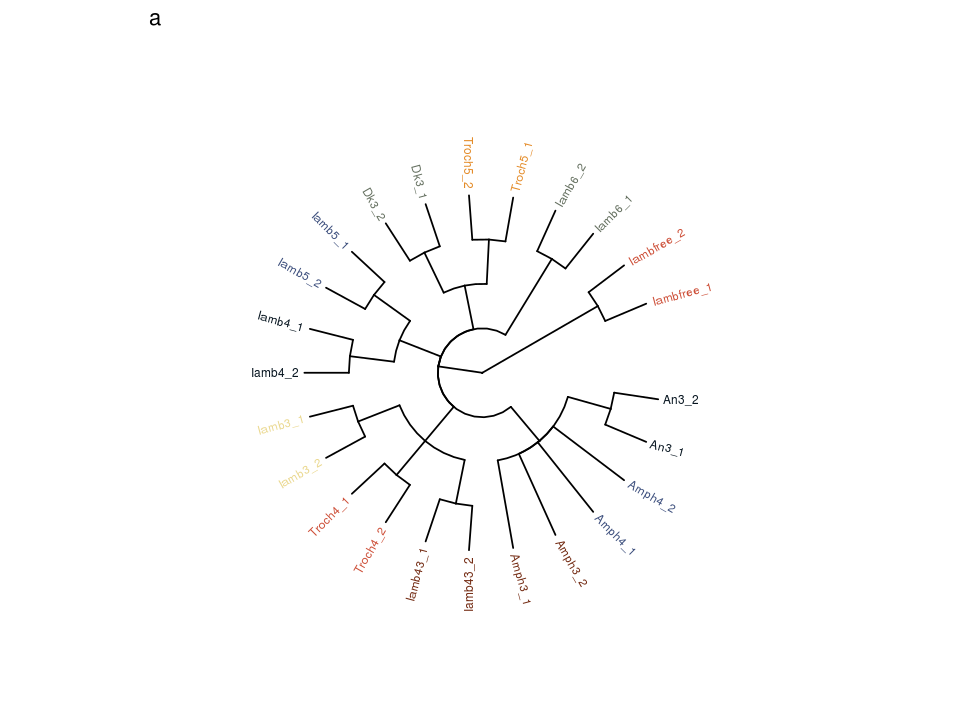

In [4]:
cons_plot1

## Metrical variants of Iamb-4

In [5]:
# use only iamb4 variants, excluding the most popular Iamb-4-fm

iamb_forms = meter_claus_count  %>% 
    filter(str_detect(meter, "Я4_"), n>=200, !str_detect(meter,"Х5|Х6"), !str_detect(meter,"_жм$"))  

iamb_forms

meter,n
<chr>,<int>
"Я4_ж,м",1709
Я4_мж,1611
Я4_м,366
Я4_дм,226


In [6]:
set.seed(123)

iamb_trees = consensus_tree_within_meter(x=unique_poems  %>% unite("meter", meter:clausula),
                           y=iamb_forms,
                           z=ru_gamma_separated,
                           sample_size=100,
                           n_samples=2,
                           n_trees = 100,
                           min_meter_count=-Inf,
                           replace=F,
                           distance="JSD",
                           clust_method="complete")

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 8 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; com

In [7]:
consensus = ape::consensus(iamb_trees, p=0.5)

plot=ggtree(consensus,layout="circular",size=0.5) 

plot$data = plot$data  %>%
         mutate(class = str_replace_all(label, "^(.*)_\\d$", "\\1"))  %>% 
         left_join(trans, by="class")  %>% 
         group_by(meter_eng)  %>% 
         mutate(sample = row_number())  %>% 
         unite(meter_eng, meter_eng:sample,sep="_")  %>% 
         ungroup()  %>% 
         mutate(label = case_when(!is.na(label) ~ meter_eng))


cons_plot2 = plot + geom_tiplab(aes(color=class),hjust=-.1,size=3) + guides(color=F) + #scale_color_paletteer_d(rep("ghibli::MononokeDark",2))
 scale_color_manual(values=c(rep(paletteer_d("ghibli::MononokeMedium"),2))) + labs(title="b") + xlim(0,8) +ylim(0,8)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



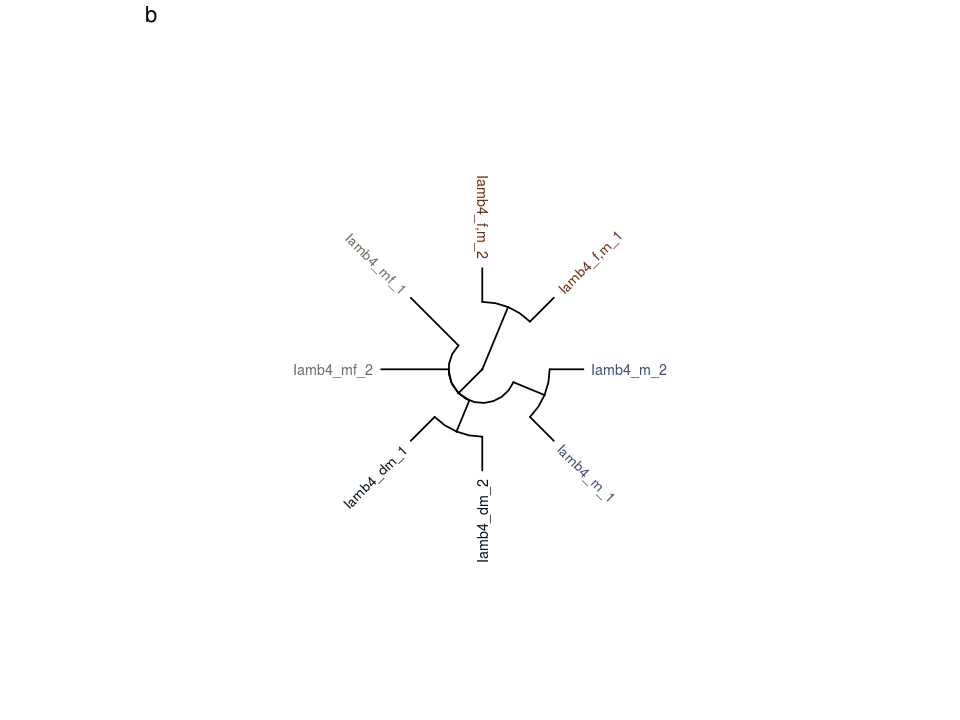

In [8]:
cons_plot2

In [ ]:
patch = cons_plot1 + cons_plot2

patch + theme(plot.margin =  margin(1, 0, 0, 1, "cm"))
ggsave("plots/consensus_trees.png", height=4, width=6)



In [ ]:
ggsave("plots/consensus_variants.png", height=5, width=6, unit="cm")

## Clustering accuracy


Check how clusterization efficiency depends on sample size (how many poems per sample) in **metrical forms** 

1) Run n iterations per sample size (poems in each sample representing meter)  
2) Measure ARI and purity in each iteration + run the same thing for randomly assigned clusters  



In [12]:
source("src/test_clusters_halo.R")

halo_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,5,10,20,40,60,80,100,120,150,200,250),
                         samples_per_meter=2,
                         iterations=50,
                         min_meter_count=500,
                         rep=FALSE,
                         clust_method="complete")

random_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,5,10,20,40,60,80,100,120,150,200,250),
                         samples_per_meter=2,
                         iterations=50,
                         min_meter_count=500,
                         rep=FALSE,
                         random_clusters=T,
                         clust_method="complete")

[1] "Now at 1 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 5 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 10 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 20 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 40 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 60 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 80 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 100 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 120 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 150 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 200 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 250 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 1 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 5 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 10 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 20 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 40 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 60 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 80 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 100 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 120 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 150 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 200 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 250 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 24 vectors.

Metric: 'jensen-shannon' using uni

In [13]:
halo_clusters  %>% filter(poems_per_sample == 250)  %>% summarise(m_ari = median(ari), m_pur = median(purity))

m_ari,m_pur
<dbl>,<dbl>
0.7286206,0.8958333


In [14]:
ari_plot = halo_clusters  %>% 
    #to long table
    mutate(ari_rand = random_clusters$ari) %>% gather(key="clust", value="index", c(1:2,4))  %>%

    ggplot(aes(as.factor(poems_per_sample), index, group=interaction(poems_per_sample,clust),color=clust)) + 
    geom_boxplot() +   
    theme_ipsum() + 
    labs(x="Sample Size", y="Value",title="c") + 
    theme(axis.title.x = element_text(size=12),
          axis.title.y = element_text(size=12),
          plot.margin  = margin(0,0,0,0)) + 
    scale_color_paletteer_d("ghibli::MononokeMedium",direction = -1)

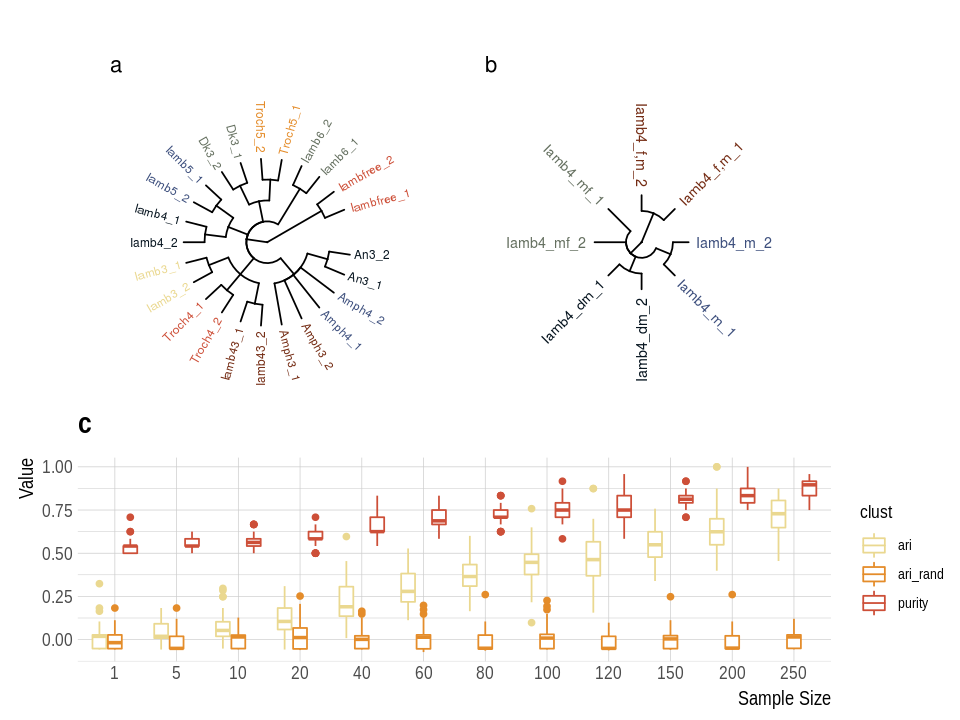

In [15]:
patch = (cons_plot1 | cons_plot2) + theme(plot.margin =  margin(1, 0, 0, 1, "cm"))
patch / ari_plot +  plot_layout(heights = c(2, 1.3))

ggsave("plots/fig2_consensus_ari.png", width=8,height=7)

/////////////////////
## XX. Code Graveyard (really, pls, do not go there)

////////////////////

In [ ]:
source("src//test_clusters_halo.R")
source("src//poem_sampler.R")
halo_clusters = test_clusters_halo(poem_list=unique_poems,
                         meter_list=meter_count,
                         p_size=c(1,seq(5,50, by=5)),
                         samples_per_meter=2,
                         iterations=50,
                         max_meter_count=200,
                         min_meter_count=100,
                         rep=F)

In [ ]:
halo_clusters %>% gather(key="clust", value="index", 1:2)  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(poems_per_sample,clust),color=clust)) + geom_boxplot()  

## Metrical variants simplification

1) It's is wrong to assume that all catalectic variants of metrical form formed equally distinct semantics, e.g. alternation of f/m or m/f in Iambic tetrameter or irregular alternation of f/m clausula.  
2) To trace those "sibling" variants we perform series of clusterization using metrical variants and simply look how "dispersed" is each variant across cluster.  
3) We simply count mean number of clusers each form appears in. Ideal clustering would be 1, very bad = 3.  
4) We look what forms are on average dispersed over more than 2 clusters and -> based on this simplify semantically close variants merging them to one.

In [ ]:
ari_vec = vector(length=50)
purity_vec = vector(length=50)

cluster_df = meter_claus_count  %>% filter(n>=400)  %>% select(meter,n) %>% arrange(meter)  %>% mutate(n_clust = 0)


for (i in 1:length(ari_vec)) {

print(paste("Now at", i, sep=" "))
## take 3 samples per each meter
wide_gamma = poem_sampler(x= unique_poems  %>% unite("meter", meter:clausula),
             y=meter_claus_count,
             sample_size=100,
             n_samples=3,
             meter_count_limit=400,
             replace=F) %>% 
    left_join(ru_gamma_separated)  %>%
#    mutate(sample = str_replace(sample,"^.*?_", "")) %>%
    group_by(topic, sample)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)

## perpare matrix
names = wide_gamma  %>% pull(sample)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization

tree = wide_matrix  %>% 
    dist(method="Kullback")  %>% 
    hclust(method="ward.D2") 


n_classes = meter_claus_count  %>% 
    filter(n>=400)  %>%
    pull(meter)  %>%
    length()

classes = cutree(tree,k=n_classes)
expected = str_replace_all(names, "_\\d", "")

purity = NMF::purity(as.factor(classes), expected)
ari = mclust::adjustedRandIndex(as.numeric(classes), expected)

    
## checking which forms cluster badly
triplets = split(as.numeric(classes), ceiling(seq_along(classes)/3))
clusters_per_class = sapply(triplets,unique)  %>% sapply(length)

cluster_df = cluster_df  %>% mutate(n_clust = n_clust + clusters_per_class)
    

purity_vec[i] = purity
ari_vec[i] = ari
}

cluster_df = cluster_df  %>% mutate(avg_clust = n_clust/length(ari_vec))

In [ ]:
cluster_df  %>% filter(avg_clust > 2)

## Remove uninformative variants from data

1) As expected, the most cluster dispersion happened in common f/m or m/f alternating catalectic variants  
2) We remove those variants, leaving the most common form which is f/m regular alternation for Iamb-4, Iamb-5, Iamb-6 & Troch-4

In [ ]:
# metrical variants with bad clustering


m_claus_simplified = meter_claus_count  %>%
    filter(!meter %in% c("Х4_ж,м","Я4_ж,м","Я4_мж","Я5_ж,м","Я6_ж,м"))

unique_poems_simplified = unique_poems  %>% unite("meter", meter:clausula)  %>%
         filter(!meter %in% c("Х4_ж,м","Я4_ж,м","Я4_мж","Я5_ж,м","Я6_ж,м"))

head(m_claus_simplified)


## Clustering performance on simplified metrical variants

In [ ]:
variants_simple_res = test_clusters_halo(poem_list=unique_poems_simplified,
                         meter_list=m_claus_simplified,
                         p_size=c(seq(10,120,by=10)),
                         samples_per_meter=3,
                         iterations=50,
                         min_meter_count=400,          
                         rep=FALSE)

variants_res = test_clusters_halo(poem_list=unique_poems  %>% unite("meter", meter:clausula),
                         meter_list=meter_claus_count,
                         p_size=c(seq(10,120,by=10)),
                         samples_per_meter=3,
                         iterations=50,
                         min_meter_count=400,          
                         rep=FALSE)

## smaller meters


In [ ]:
mean(variants_simple_res$ari)
mean(variants_res$ari)

variants_simple_res  %>% mutate(ari_vanilla = variants_res$ari) %>% 
    gather(key="clust", value="index", c(1:2,4))  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(clust,poems_per_sample),color=clust)) + geom_boxplot()

In [ ]:
variants_small = test_clusters_halo(poem_list=unique_poems  %>% unite("meter", meter:clausula),
                         meter_list=meter_claus_count,
                         p_size=c(5,seq(10,100,by=10)),
                         samples_per_meter=2,
                         iterations=100,
                         min_meter_count=200,
                         max_meter_count=400,          
                         rep=FALSE)


In [ ]:
variants_small  %>% gather(key="clust", value="index", c(1:2))  %>% 
    ggplot(aes(poems_per_sample, index, group=interaction(clust,poems_per_sample),color=clust)) + geom_boxplot()

## XX. Code backyard

In [ ]:
ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=2) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d("ghibli::MononokeMedium") +
  guides(color=F) +
  labs(subtitle=paste("Cluster purity: ", round(purity,2)))

### Draw a dendrogram out of single clusterization

In [ ]:

## take 3 samples per each meter
wide_gamma = poem_sampler(x= unique_poems,  #%>% unite("meter", meter:clausula),
             y=meter_count,
             sample_size=250,
             n_samples=2,
             meter_count_limit=500,
             replace=F) %>% 
    left_join(ru_gamma_separated)  %>%
#    mutate(sample = str_replace(sample,"^.*?_", "")) %>%
    group_by(topic, sample)  %>% 
    summarise(m_gamma = mean(gamma))  %>% 
    spread(key = topic, value=m_gamma)

## perpare matrix
names = wide_gamma  %>% pull(sample)
wide_matrix = wide_gamma[,-1]  %>% as.matrix()
rownames(wide_matrix) =  names


##calculate distances & build clusterization

tree = wide_matrix  %>% 
#    scale()  %>% 
    dist(method="Kullback")  %>% 
    hclust(method="ward.D2") 


n_classes = meter_count  %>% 
    filter(n>=400)  %>%
    pull(meter)  %>%
    length()

classes = cutree(tree,k=n_classes)
expected = str_replace_all(names, "_\\d", "")


purity = NMF::purity(as.factor(classes), expected)
ari = mclust::adjustedRandIndex(as.numeric(classes), expected)

ggtree = tree  %>%
    as.dendrogram() %>%
    dendro_data()

ggtree$labels = ggtree$labels %>%
  mutate(m_family = str_replace(label, "^(.*?)\\d.*", "\\1"),
         m_family = str_replace(m_family, "Явольн", "Я"))

ggplot() +
  geom_segment(data=ggtree$segments,aes(x,y,xend=xend, yend=yend),size=0.5) + # map segments/branches
  geom_text(data=ggtree$labels, aes(x,y,label=label, color=m_family), hjust=1.1, angle=0, size=2) + # map labels
  coord_flip() +
  scale_y_continuous(expand=c(0.2, 0)) +
  theme_dendro() +
  scale_color_paletteer_d("ghibli::MononokeMedium") +
  guides(color=F) +

labs(subtitle=paste("Cluster purity: ", round(purity,2),"\nARI: ", round(ari,2)))